This notebook contains code to extract features from the audio signals.

In [14]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [15]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [16]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [17]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

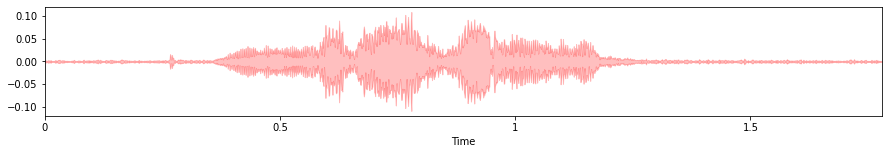

In [18]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

In [19]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00912
Signal std dev = 0.01691


RMSE mean = 0.01116
RMSE std dev = 0.01265


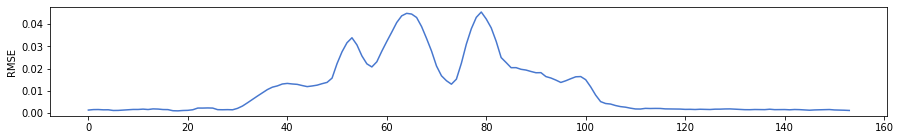

In [20]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [21]:
from IPython.display import Audio
Audio(y, rate=44100)

In [22]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.5324675324675324


In [23]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-8.111131e-06

In [24]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

22.440069614225152

In [25]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

17.485857887083007

In [29]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [30]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [40]:
audio_vectors

{'Ses05F_script02_1_F000': array([-0.00042757, -0.00034048, -0.00023222, ...,  0.00086239,
         0.00095952,  0.0010099 ], dtype=float32),
 'Ses05F_script02_1_F001': array([-0.02716193, -0.02862036, -0.02938998, ..., -0.00188805,
        -0.00246372, -0.00314347], dtype=float32),
 'Ses05F_script02_1_F002': array([0.0054327 , 0.0053122 , 0.00523707, ..., 0.00185941, 0.00185343,
        0.00173765], dtype=float32),
 'Ses05F_script02_1_F003': array([-0.00097966, -0.00099522, -0.00102263, ..., -0.00026784,
        -0.00037902, -0.00055037], dtype=float32),
 'Ses05F_script02_1_F004': array([-0.00037312, -0.00027858, -0.00015289, ...,  0.04314281,
         0.04220507,  0.04106287], dtype=float32),
 'Ses05F_script02_1_F005': array([0.00654499, 0.00664308, 0.00669657, ..., 0.00098588, 0.00093138,
        0.00093003], dtype=float32),
 'Ses05F_script02_1_F006': array([-0.00153627, -0.00107162, -0.00053242, ...,  0.00035021,
         0.00038152,  0.00048742], dtype=float32),
 'Ses05F_script02_

In [41]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std

                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')
                print(wav_file_name)

df_features.to_csv('data/pre-processed/audio_features.csv', index=False)

554it [00:00, 2759.74it/s]

Some exception occured
Ses01F_impro03_F000
Some exception occured
Ses01F_impro03_F001
Some exception occured
Ses01F_impro03_F002
Some exception occured
Ses01F_impro03_F003
Some exception occured
Ses01F_impro03_F004
Some exception occured
Ses01F_impro03_F005
Some exception occured
Ses01F_impro03_F006
Some exception occured
Ses01F_impro03_F007
Some exception occured
Ses01F_impro03_F008
Some exception occured
Ses01F_impro03_F009
Some exception occured
Ses01F_impro03_F010
Some exception occured
Ses01F_impro03_F011
Some exception occured
Ses01F_impro03_F012
Some exception occured
Ses01F_impro03_F013
Some exception occured
Ses01F_impro03_F014
Some exception occured
Ses01F_impro03_F015
Some exception occured
Ses01F_impro03_F016
Some exception occured
Ses01F_impro03_F017
Some exception occured
Ses01F_impro03_F018
Some exception occured
Ses01F_impro03_F019
Some exception occured
Ses01F_impro03_F020
Some exception occured
Ses01F_impro03_F021
Some exception occured
Ses01F_impro03_F022
Some except

1110it [00:00, 2752.58it/s]


Ses01F_script02_2_F027
Some exception occured
Ses01F_script02_2_F028
Some exception occured
Ses01F_script02_2_F029
Some exception occured
Ses01F_script02_2_F030
Some exception occured
Ses01F_script02_2_F031
Some exception occured
Ses01F_script02_2_F032
Some exception occured
Ses01F_script02_2_F033
Some exception occured
Ses01F_script02_2_F034
Some exception occured
Ses01F_script02_2_F035
Some exception occured
Ses01F_script02_2_F036
Some exception occured
Ses01F_script02_2_F037
Some exception occured
Ses01F_script02_2_F038
Some exception occured
Ses01F_script02_2_F039
Some exception occured
Ses01F_script02_2_F040
Some exception occured
Ses01F_script02_2_F041
Some exception occured
Ses01F_script02_2_F042
Some exception occured
Ses01F_script02_2_F043
Some exception occured
Ses01F_script02_2_F044
Some exception occured
Ses01F_script02_2_F045
Some exception occured
Ses01F_script02_2_F046
Some exception occured
Ses01F_script02_2_F047
Some exception occured
Ses01F_script02_2_M000
Some excep

1669it [00:00, 2772.84it/s]


Ses01M_impro05_F007
Some exception occured
Ses01M_impro05_F008
Some exception occured
Ses01M_impro05_F009
Some exception occured
Ses01M_impro05_F010
Some exception occured
Ses01M_impro05_F011
Some exception occured
Ses01M_impro05_F012
Some exception occured
Ses01M_impro05_F013
Some exception occured
Ses01M_impro05_F014
Some exception occured
Ses01M_impro05_F015
Some exception occured
Ses01M_impro05_F016
Some exception occured
Ses01M_impro05_F017
Some exception occured
Ses01M_impro05_F018
Some exception occured
Ses01M_impro05_F019
Some exception occured
Ses01M_impro05_F020
Some exception occured
Ses01M_impro05_F021
Some exception occured
Ses01M_impro05_F022
Some exception occured
Ses01M_impro05_F023
Some exception occured
Ses01M_impro05_F024
Some exception occured
Ses01M_impro05_F025
Some exception occured
Ses01M_impro05_F026
Some exception occured
Ses01M_impro05_F027
Some exception occured
Ses01M_impro05_F028
Some exception occured
Ses01M_impro05_F029
Some exception occured
Ses01M_imp

1819it [00:00, 2755.22it/s]


Some exception occured
Ses01F_script01_3_F015
Some exception occured
Ses01F_script01_3_F016
Some exception occured
Ses01F_script01_3_F017
Some exception occured
Ses01F_script01_3_F018
Some exception occured
Ses01F_script01_3_F019
Some exception occured
Ses01F_script01_3_F020
Some exception occured
Ses01F_script01_3_F021
Some exception occured
Ses01F_script01_3_F022
Some exception occured
Ses01F_script01_3_F023
Some exception occured
Ses01F_script01_3_F024
Some exception occured
Ses01F_script01_3_F025
Some exception occured
Ses01F_script01_3_F026
Some exception occured
Ses01F_script01_3_F027
Some exception occured
Ses01F_script01_3_F028
Some exception occured
Ses01F_script01_3_F029
Some exception occured
Ses01F_script01_3_F030
Some exception occured
Ses01F_script01_3_F031
Some exception occured
Ses01F_script01_3_F032
Some exception occured
Ses01F_script01_3_F033
Some exception occured
Ses01F_script01_3_F034
Some exception occured
Ses01F_script01_3_F035
Some exception occured
Ses01F_scr

FileNotFoundError: [Errno 2] No such file or directory: 'data/pre-processed/audio_vectors_2.pkl'